In [1]:
# Basic imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data import

We start by importing our processed data, dropping columns unhelpful for classification, and pulling out the target column from the rest of the observations.

In [2]:
dnd = pd.read_csv("dnd_monsters_processed.csv")
dnd = dnd.drop(columns=["Index", "name", "size", "type"])
X = dnd.drop(columns=["cr"]).to_numpy()
y = dnd.cr.to_numpy()

Here's a visual for how many monsters are in each challenge rating class.

Text(0, 0.5, 'Count')

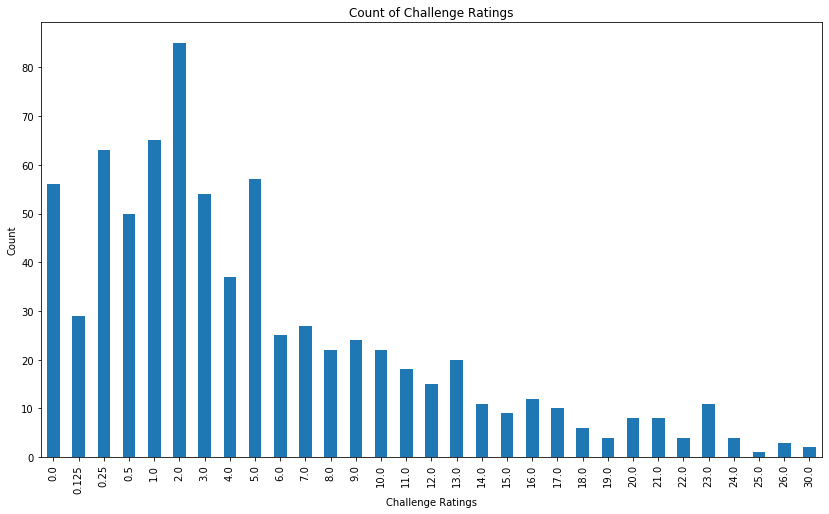

In [3]:
ax = dnd.cr.value_counts().sort_index().plot(kind='bar', figsize=(14,8),title="Count of Challenge Ratings")
ax.set_xlabel("Challenge Ratings")
ax.set_ylabel("Count")

Since not all models can take real-numbered targets, we also create a shifted target vector that converts the fractional challenge ratings the lowest-valued integers and shift the rest of the challenge ratings to accommodate them.

In [4]:
y_shift = []
for i in y:
    if i == .125:
        y_shift.append(1)
    elif i == .25:
        y_shift.append(2)
    elif i == .5:
        y_shift.append(3)
    else:
        y_shift.append(i+3)

# Testing Methods

To run our experiments, we created a helper function that takes a model, the observations, target values, and a number of trials to run. This allowed us to easily run experiments per model and find an average score for them.

In [5]:
def test_model(model, X, y, trials):
    test = []
    train = []
    for i in range(trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y)    
        model.fit(X_train, y_train)
        test.append(model.score(X_test, y_test))
        train.append(model.score(X_train, y_train))

    print("Accuracy on training set: {:.5f}".format(np.mean(train)))
    print("Accuracy on test set: {:.5f}".format(np.mean(test)))

# KNN Classification and Regression

As a baseline, we first started by trying to use knn classification and regression schemes. Since knn models cannot use continuous target values, we had to use the shifted targets. Starting with knn classification, we see that it wasn't very effective.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(15)
test_model(knn, X, y_shift, 100)

Accuracy on training set: 0.39387
Accuracy on test set: 0.27728


But when using the knn regression model, we find that it works much better.

In [7]:
from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor(15)
test_model(knn_reg, X, y_shift, 100)

Accuracy on training set: 0.91901
Accuracy on test set: 0.90556


# Linear Regression

Seeing that regression worked better than classification, we continue down the regression path and use the linear regression model. This ran much faster compared to knn regression, but had a slight hit to accuracy.

In [8]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
test_model(lr, X, y, 100)

Accuracy on training set: 0.90457
Accuracy on test set: 0.89272


# MLP Regression

We then used a multilevel perception model. This was the slowest to run of them all, so we had to reduce the number of trials to get results in a reasonable amount of time, but it had the most accuracy overall.

In [9]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor()
test_model(mlp, X, y, 10)

/usr/local/lib64/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib64/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib64/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib64/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarni

Accuracy on training set: 0.94743
Accuracy on test set: 0.92122


/usr/local/lib64/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
